# Credit Card Customer Churn - Preprocessing

This notebook builds upon the insights obtained during the exploratory data analysis phase and focuses on transforming the raw dataset into a modeling-ready format. The preprocessing steps implemented here are directly informed by the behavioral patterns and data characteristics identified earlier, ensuring that all transformations are evidence-driven rather than arbitrary.

## 1. Initial Overview

### Data Loading

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

path = "../data/BankChurners_clean.csv"
df = pd.read_csv(path)

df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 2. Categorical Features

### Merging

As identified during the exploratory process, several categorical variables exhibit low cardinality and imbalanced distributions. Therefore, some categories will be selectively merged in ways that reflect meaningful behavioral or risk-related distinctions observed in the data. Specifically, we will follow the strategies of merging Advanced Degrees in `Education_Level` and the Non-Blue cards in `Card_Category`.

In [2]:
df['Education_Level'] = df['Education_Level'].replace(['Doctorate', 'Post-Graduate'], 'Advanced_Degree')
df['Card_Category'] = df['Card_Category'].replace(['Silver', 'Gold', 'Platinum'], 'Non_Blue')

In [3]:
cols = ['Education_Level', 'Card_Category']

for col in cols:
    print(f'Unique values for {col}: {df[col].unique()}\n')

Unique values for Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College'
 'Advanced_Degree']

Unique values for Card_Category: ['Blue' 'Non_Blue']



### Encoding

#### Binary Encoding (Mapping)

The columns `Attrition_Flag`, `Gender` and `Card_Category` are suitable for binary mapping. While `Attrition_Flag` and `Gender` are naturally binary, `Card_Category` has been reduced to two distinct classes in the previous merging step.

In [4]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})
df['Card_Category'] = df['Card_Category'].map({'Blue': 0, 'Non_Blue': 1})

#### Ordinal Encoding

The columns `Education_Level` and `Income_Category` are suitable for ordinal encoding, as they represent ordered categories. However, both columns include missing information labeled as "Unknown" and, to address this, these values will be encoded as -1. This strategy preserves the ordinal hierarchy of the known categories (1 to 5) while treating missing data as a distinct and isolated group that the model can learn from.

In [5]:
education_mapping = {
    'Unknown': -1,
    'Uneducated': 1,
    'High School': 2,
    'College': 3,
    'Graduate': 4,
    'Advanced_Degree': 5
}

income_mapping = {
    'Unknown': -1,
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5
}

df['Education_Level'] = df['Education_Level'].map(education_mapping)
df['Income_Category'] = df['Income_Category'].map(income_mapping)

#### One-Hot Encoding

The column `Marital_Status` is suitable for one-hot encoding, as it is a nominal categorical variable without an intrinsic order.

In [6]:
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True, dtype=int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  int64  
 5   Income_Category           10127 non-null  int64  
 6   Card_Category             10127 non-null  int64  
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

## 3. Numerical Features

### Removing Redundancy

As previously perceived in the EDA, the variable `Avg_Open_To_Buy` exhibits a perfect linear relationship with `Credit_Limit`. This is expected, as `Avg_Open_To_Buy` is mathematically derived by simply subtracting `Total_Revolving_Bal` from `Credit_Limit`. To avoid perfect multicollinearity and eliminate redundancy, this column will be removed.

In [8]:
df = df.drop('Avg_Open_To_Buy', axis=1)
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown'],
      dtype='object')

### 36-Month Tenure Spike Correction

Also during the exploratory analysis, a pronounced spike at exactly 36 months of tenure was identified, indicating a systematic artifact rather than a natural behavioral pattern. Such concentration at a single value suggests prior imputation or a data collection shortcut, which could bias downstream models by introducing an artificial mode.

Given the strong linear relationship between customer age and tenure in the non-anomalous data, a regression-based imputation approach was adopted. To avoid a purely deterministic mapping, stochastic variation derived from empirical residuals was added, preserving both the global trend and natural variability. The objective is **not** to recover the original organic distribution at 36 months - which is statistically impossible after deterministic collapse - but to redistribute the contaminated mass in a manner consistent with the structure and variance observed in the clean data.

#### Reproducibility and Model Setup

A fixed random seed is defined to ensure reproducibility of the stochastic components and a simple linear regression model is used to capture the dominant age–tenure relationship.

In [10]:
import numpy as np

np.random.seed(42)

#### Identifying Normal Observations and Anomalies

The dataset is partitioned into two subsets:

- Clean observations, which do not exhibit the 36-month anomaly and are used to estimate the underlying relationship.
- Anomalous observations, concentrated at 36 months, which will be corrected through imputation.

In [11]:
mask_real = df['Months_on_book'] != 36
mask_anomaly = df['Months_on_book'] == 36

df_real = df.loc[mask_real]
df_anomaly = df.loc[mask_anomaly]

#### Linear Model Estimation on Clean Data

A simple linear regression model is trained using customer age as the explanatory variable and tenure as the response. This intentionally simple specification captures the dominant structural signal without introducing unnecessary complexity.

In [12]:
from sklearn.linear_model import LinearRegression

X_train = df_real[['Customer_Age']]
y_train = df_real['Months_on_book']

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f"R² at clean data: {lr.score(X_train, y_train):.4f}")

R² at clean data: 0.7971


#### Empirical Residual Analysis

To characterize the natural dispersion around the estimated linear trend, residuals are computed on the clean training data.

In [13]:
y_pred_train = lr.predict(X_train)
residuals = y_train - y_pred_train

The visual inspection below shows that the residual distribution is strongly asymmetric and violates standard parametric assumptions (normality or symmetry). This behavior reflects structural constraints in the data, such as older customers opening accounts recently, which allow for large negative errors but limit positive ones. Assuming a parametric noise distribution would introduce unrealistic error patterns so, to preserve the empirical error structure, a non-parametric residual bootstrapping strategy is adopted.

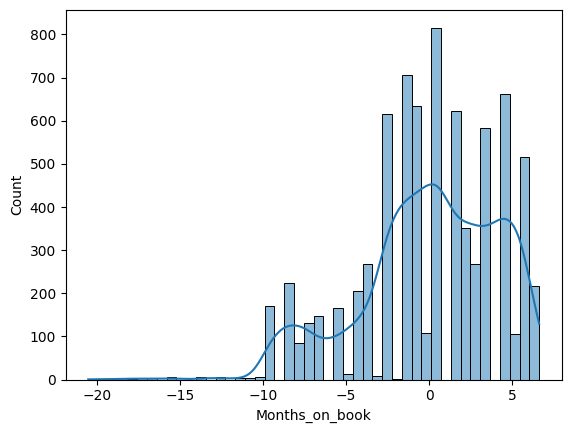

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(residuals, kde=True)
plt.show()

#### Stochastic Imputation via Residual Bootstrapping

Tenure values for anomalous observations are first predicted using the estimated linear relationship. Stochastic variation is then introduced by resampling directly from the empirical residual distribution.

This bootstrapping approach preserves the exact error structure observed in real data, including skewness and boundedness, thereby generating imputed values that better reflect plausible customer tenure trajectories.

In [15]:
X_predict = df_anomaly[['Customer_Age']]
predicted_values = lr.predict(X_predict)

noise = np.random.choice(residuals, size=len(predicted_values), replace=True)

imputed_values = predicted_values + noise
imputed_values = imputed_values.round().clip(min=13)

To validate this approach, the distributions of the original residuals and the bootstrapped noise are compared below, confirming their close alignment.

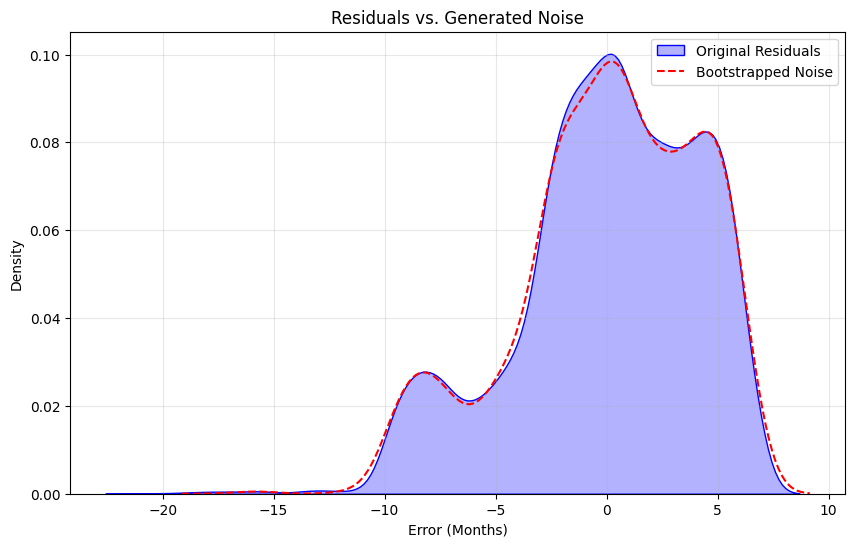

In [16]:
plt.figure(figsize=(10, 6))

sns.kdeplot(residuals, label='Original Residuals', fill=True, alpha=0.3, color='blue')
sns.kdeplot(noise, label='Bootstrapped Noise', linestyle='--', color='red')

plt.title('Residuals vs. Generated Noise')
plt.xlabel('Error (Months)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Dataset Reconstruction

Finally, the corrected tenure values are reintegrated into the dataset. The original index order is preserved to ensure consistency for subsequent preprocessing and modeling stages.

In [17]:
df_anomaly.loc[:, 'Months_on_book'] = imputed_values.astype(int)
df = pd.concat([df_real, df_anomaly], axis=0).sort_index()

#### Confirmation Plots

##### Customer Age vs. Months on Book

Now, we revisit a scatter plot previously explored during the EDA, depicting the relationship between customer age and tenure. In the original dataset, a pronounced artifact was evident: customers across a wide age range (from their early 20s to late 60s) were concentrated at exactly 36 months of tenure, indicating a naive and unrealistic imputation pattern.

After the correction, this artificial concentration is no longer present. The tenure values now follow a smoother and more plausible linear relationship with age, consistent with the structure observed in the unaffected data. This confirms that the imputation preserved the underlying behavioral trend while restoring natural variability, resulting in a distribution that better reflects real-world customer tenure dynamics.

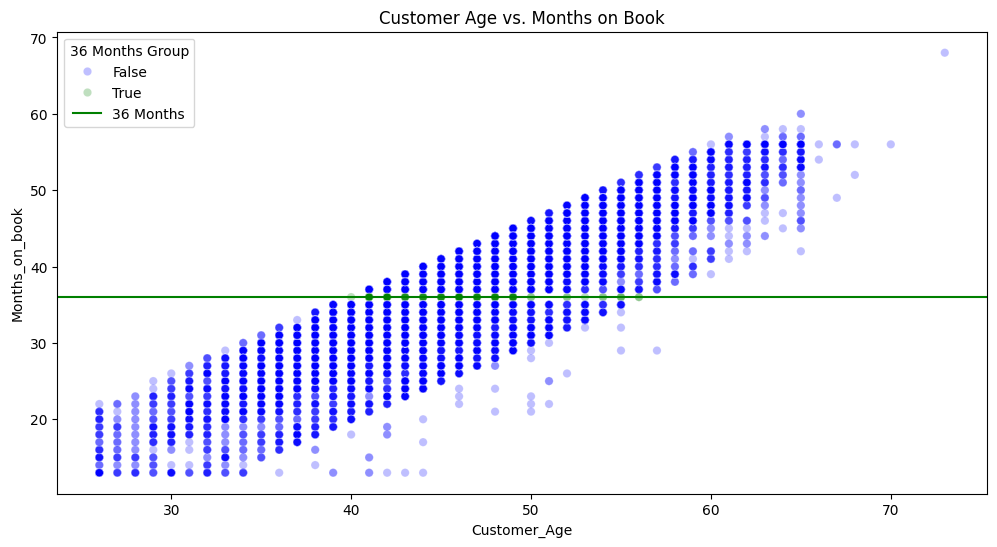

In [18]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=df, x='Customer_Age', y='Months_on_book', hue=(df['Months_on_book'] == 36), 
                palette={True: 'green', False: 'blue'}, alpha=0.25)

plt.title('Customer Age vs. Months on Book')
plt.axhline(36, color='green', linestyle='-', label='36 Months')
plt.legend(title='36 Months Group')

plt.show()

##### Months on Book Distributions


To conclude this section, we analyze the distribution of the tenure variable before and after the correction process.  The left plot shows the distribution of the real observations, following a near-normal shape and exhibiting a clear structural gap at 36 months, reflecting the removal of the contaminated value.

The right plot presents the distribution after the regression-based imputation with bootstrapped residuals. The artificial spike at 36 months is eliminated, while the macroscopic shape of the distribution remains consistent. The lower density observed around 36 months is a natural artifact of the stochastic dispersion, confirming that the concentrated mass was redistributed based on feature correlation rather than artificially smoothed. This outcome is desirable: it eliminates bias while preserving the structural asymmetry and variance of the real-world data.

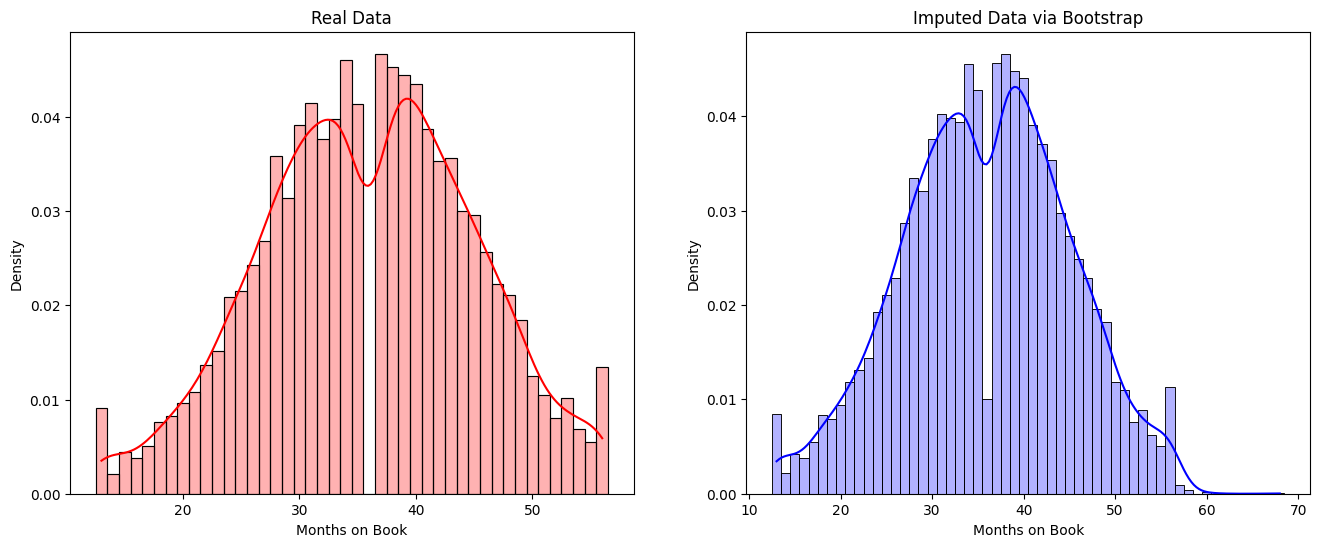

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


sns.histplot(data=df_real, x='Months_on_book', kde=True, stat="density", discrete=True, color='red', alpha=0.3, ax=axes[0])
axes[0].set_title('Real Data')
axes[0].set_xlabel('Months on Book')
axes[0].set_ylabel('Density')

sns.histplot(data=df, x='Months_on_book', kde=True, stat="density", 
             discrete=True, color='blue', alpha=0.3, ax=axes[1])
axes[1].set_title('Imputed Data via Bootstrap')
axes[1].set_xlabel('Months on Book')
axes[1].set_ylabel('Density')

plt.show()

### Feature Engineering

#### Average Ticket Size

The exploratory analysis indicated that churn is driven more by transactional frequency than by absolute monetary value. High-frequency customers show strong retention even at low spending levels, while low-frequency behavior increases churn risk across all volumes.

This suggests that frequency and value interact rather than act independently. To capture this interaction, a new behavioral feature, `Avg_Ticket_Size`, defined as the ratio of total transaction amount to transaction count, is introduced. This metric differentiates frequent low-value behavior from infrequent high-value transactions, providing a more nuanced and interpretable representation of customer engagement.

In [20]:
df['Avg_Ticket_Size'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df[['Avg_Ticket_Size']].head()

,Avg_Ticket_Size
0,27.238095
1,39.121212
2,94.350000
3,58.550000
4,29.142857


## 4. Saving the Dataset

After completing the preprocessing pipeline, a finalized version of the dataset is persisted. This snapshot represents a model-ready state, consolidating all preprocessing decisions while preserving reproducibility and traceability.

In [21]:
df.to_csv("../data/BankChurners_processed.csv", index=False)

---
<center>
  <div style="font-size: 0.85em; color: #555;">
    This notebook was developed as part of a personal data science portfolio project focused on customer churn prediction.</br>
    Author: Pedro Siqueira.</br>
    <a href="https://www.linkedin.com/in/phenriquels/" target="_blank">LinkedIn</a> ·
    <a href="https://github.com/phenriquels01" target="_blank">GitHub</a>
  </div>
</center>
